# 数据预处理
## 信息
### 描述信息(来自网站)
 1. 数据为2020年5月-2021年5月的数据
 2. 总共有5800辆车，总共有600个停车桩
### 数据清洗（kaggle上的v2.csv版本就是已处理的）
 1. 骑行时长不到一分钟的记为无效记录（kaggle）
 2. 骑行结束时间小于开始时间的为无效记录
### 数据信息（来自文件，并未使用）
 1. 总共有3498686条数据
 2. 不同的station在710个
 3. 有不同类型的用户member和casual
 4. 有不同类型的车子docked_bike、electric_bike、classic_bike
## 目标
 1. 估算合理的早晚划分
 2. 根据前一晚的supply保留第二天的demand
 3. 划分格子点

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import calendar

In [2]:
all_trips_v2 = pd.read_csv("./all_trips_v2.csv")
all_trips_v2.head()

,Unnamed: 0,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,date,month,day,year,day_of_week,ride_length
0,1,docked_bike,2020-05-27 10:03:52,2020-05-27 10:16:49,Franklin St & Jackson Blvd,Wabash Ave & Grand Ave,41.8777,-87.6353,41.8915,-87.6268,member,2020-05-27,5,27,2020,Wednesday,12.950000
1,2,docked_bike,2020-05-25 10:47:11,2020-05-25 11:05:40,Clark St & Wrightwood Ave,Clark St & Leland Ave,41.9295,-87.6431,41.9671,-87.6674,casual,2020-05-25,5,25,2020,Monday,18.483333
2,3,docked_bike,2020-05-02 14:11:03,2020-05-02 15:48:21,Kedzie Ave & Milwaukee Ave,Kedzie Ave & Milwaukee Ave,41.9296,-87.7079,41.9296,-87.7079,casual,2020-05-02,5,2,2020,Saturday,97.300000
3,4,docked_bike,2020-05-02 16:25:36,2020-05-02 16:39:28,Clarendon Ave & Leland Ave,Lake Shore Dr & Wellington Ave,41.9680,-87.6500,41.9367,-87.6368,casual,2020-05-02,5,2,2020,Saturday,13.866667
4,5,docked_bike,2020-05-29 12:49:54,2020-05-29 13:27:11,Hermitage Ave & Polk St,Halsted St & Archer Ave,41.8715,-87.6699,41.8472,-87.6468,member,2020-05-29,5,29,2020,Friday,37.283333


In [3]:
print(len(all_trips_v2))
print(len(all_trips_v2["start_station_name"].unique()))
print(len(all_trips_v2["end_station_name"].unique()))

3498686
705
710


先只留下骑行时长小于24小时的记录

In [4]:
data = all_trips_v2[all_trips_v2["ride_length"] <= 60*24] # 骑行时长小于24小时
data = data[(data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").date()) ==
            data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").date()))] ## 开始和结束在同一天
print(data["ride_length"].median())
print(data["ride_length"].mean())
print(data["ride_length"].max())

14.4333333333333
22.704441073690724
1376.51666666667


### 查看记录分布情况

In [5]:
# 按照"month"和"day"进行分组，统计2020每一天有多少条记录
daily_counts = data[data["year"] == 2020].groupby(["month", "day"]).size()

# 计算平均每天的记录数
average_daily_count = daily_counts.mean()
average_daily_count

11696.213991769548

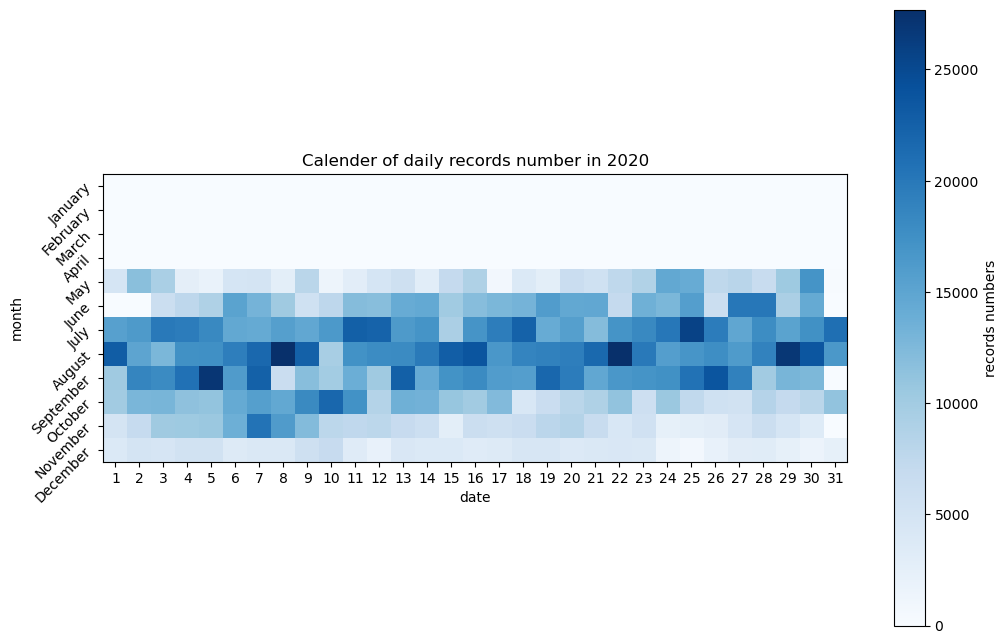

In [26]:
# 筛选出"year"字段等于2020的记录,按照"year"、"month"和"day"进行分组，统计每天的记录数
daily_counts = data[data["year"] == 2020].groupby(["year", "month", "day"]).size().reset_index(name='count')

# 获取数据的日期范围
dates = pd.date_range(start='2020-01-01', end='2020-12-31')

# 创建一个二维数组来存储每天的记录数
records = np.zeros((len(calendar.month_name) - 1, calendar.monthrange(2020, 12)[1]))

# 填充每天的记录数
for index, row in daily_counts.iterrows():
    records[row['month'] - 1][row['day'] - 1] = row['count']

# 创建一个日历图
fig, ax = plt.subplots(figsize=(12, 8))

# 根据记录数量设置颜色的深浅
cmap = plt.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=records.max())
colors_array = cmap(norm(records))

# 绘制日历图
calmap = ax.imshow(colors_array, cmap=cmap, norm=norm)
cbar = fig.colorbar(calmap, ax=ax, orientation='vertical')
cbar.set_label('records numbers')

# 设置图形标题和标签
plt.title('Calender of daily records number in 2020')
plt.xlabel('date')
plt.ylabel('month')

# 标记月份
ax.set_yticks(np.arange(len(calendar.month_name) - 1))
ax.set_yticklabels(calendar.month_name[1:], rotation=45)
ax.set_xticks(np.arange(31))
ax.set_xticklabels(np.arange(1, 32))

# 显示图形
plt.show()

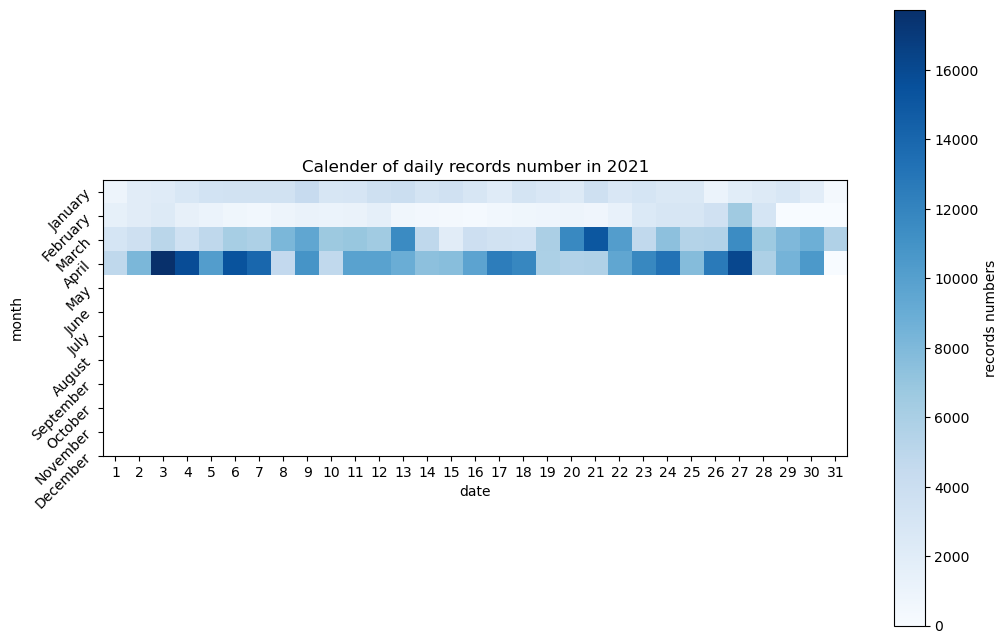

In [27]:
# 筛选出"year"字段等于2020的记录,按照"year"、"month"和"day"进行分组，统计每天的记录数
daily_counts = data[data["year"] == 2021].groupby(["year", "month", "day"]).size().reset_index(name='count')

# 获取数据的日期范围
dates = pd.date_range(start='2021-01-01', end='2021-12-31')

# 创建一个二维数组来存储每天的记录数
records = np.zeros((4, calendar.monthrange(2021, 12)[1]))

# 填充每天的记录数
for index, row in daily_counts.iterrows():
    records[row['month'] - 1][row['day'] - 1] = row['count']

# 创建一个日历图
fig, ax = plt.subplots(figsize=(12, 8))

# 根据记录数量设置颜色的深浅
cmap = plt.get_cmap('Blues')
norm = colors.Normalize(vmin=0, vmax=records.max())
colors_array = cmap(norm(records))

# 绘制日历图
calmap = ax.imshow(colors_array, cmap=cmap, norm=norm)
cbar = fig.colorbar(calmap, ax=ax, orientation='vertical')
cbar.set_label('records numbers')

# 设置图形标题和标签
plt.title('Calender of daily records number in 2021')
plt.xlabel('date')
plt.ylabel('month')

# 标记月份
ax.set_yticks(np.arange(len(calendar.month_name) - 1))
ax.set_yticklabels(calendar.month_name[1:], rotation=45)
ax.set_xticks(np.arange(31))
ax.set_xticklabels(np.arange(1, 32))

# 显示图形
plt.show()

### 估算早晚数量

In [8]:
def fit_record(start_time, end_time, day_of_week, data):
    # 将字符串时间转换为datetime对象
    start_dt = dt.strptime(start_time, "%H:%M")
    end_dt = dt.strptime(end_time, "%H:%M")

    # 筛选出符合条件的行
    filtered_data = data[(data["day_of_week"] == day_of_week) & 
                         (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt.time()) &
                         (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt.time())]

    
    return filtered_data

def choose_weekday(year, month, m_s, m_e, e_s, e_e, data):
    data = data[(data["year"] == year) & (data["month"] == month)]
    m = fit_record(m_s, m_e, "Monday", data) # 实际需求
    e = fit_record(e_s, e_e, "Sunday", data) # 原来已有
    print("Monday",len(m),len(e))
    m = fit_record(m_s, m_e, "Tuesday", data)
    e = fit_record(e_s, e_e, "Monday", data)
    print("Tuesday",len(m),len(e))
    m = fit_record(m_s, m_e, "Wednesday", data)
    e = fit_record(e_s, e_e, "Tuesday", data)
    print("Wednesday",len(m),len(e))
    m = fit_record(m_s, m_e, "Thursday", data)
    e = fit_record(e_s, e_e, "Wednesday", data)
    print("Thursday",len(m),len(e))
    m = fit_record(m_s, m_e, "Friday", data)
    e = fit_record(e_s, e_e, "Thursday", data)
    print("Friday",len(m),len(e))

def choose_weekend(year, month, m_s, m_e, e_s, e_e, data):
    data = data[(data["year"] == year) & (data["month"] == month)]
    m = fit_record(m_s, m_e, "Saturday", data)
    e = fit_record(e_s, e_e, "Friday", data)
    print("Saturday",len(m),len(e))
    m = fit_record(m_s, m_e, "Sunday", data)
    e = fit_record(e_s, e_e, "Saturday", data)
    print("Sunday",len(m),len(e))

def cut_dataframe(year, month, m_s1, m_e1, e_s1, e_e1, m_s2, m_e2, e_s2, e_e2, data):
    # 满足year和month要求
    data = data[(data["year"] == year) & (data["month"] == month)]

    # 将字符串时间转换为datetime对象
    start_dt1 = dt.strptime(m_s1, "%H:%M")
    end_dt1 = dt.strptime(m_e1, "%H:%M")
    start_dt2 = dt.strptime(e_s1, "%H:%M")
    end_dt2 = dt.strptime(e_e1, "%H:%M")
    start_dt3 = dt.strptime(m_s2, "%H:%M")
    end_dt3 = dt.strptime(m_e2, "%H:%M")
    start_dt4 = dt.strptime(e_s2, "%H:%M")
    end_dt4 = dt.strptime(e_e2, "%H:%M")
    
    # 定义筛选条件
    # 创建label_day和label_time列
    data['label_day'] = None
    data['label_time'] = None

    data.loc[(data["day_of_week"].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt1.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt1.time()), 'label_time'] = 'morning'
    data.loc[(data["day_of_week"].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt1.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt1.time()), 'label_day'] = 'weekday'

    data.loc[(data["day_of_week"].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Sunday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt2.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt2.time()), 'label_time'] = 'evening'
    data.loc[(data["day_of_week"].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Sunday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt2.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt2.time()), 'label_day'] = 'weekday'

    data.loc[(data["day_of_week"].isin(['Saturday', 'Sunday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt3.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt3.time()), 'label_time'] = 'morning'
    data.loc[(data["day_of_week"].isin(['Saturday', 'Sunday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt3.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt3.time()), 'label_day'] = 'weekend'

    data.loc[(data["day_of_week"].isin(['Saturday', 'Friday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt4.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt4.time()), 'label_time'] = 'evening'
    data.loc[(data["day_of_week"].isin(['Saturday', 'Friday'])) &
                           (data["started_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) >= start_dt4.time()) &
                           (data["ended_at"].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S").time()) <= end_dt4.time()), 'label_day'] = 'weekend'

    # 返回满足任意条件的数据框
    return data[data['label_day'].notnull() & data['label_time'].notnull()]


<!-- choose_time(2020,9,"07:00","09:59","19:00","23:59",data)
Monday 6435 10691
Tuesday 8506 9088
Wednesday 10342 11643
Thursday 8459 15668
Friday 7952 11611
Saturday 6371 15622
Sunday 4130 15026

choose_time(2020,9,"07:00","10:59","20:00","23:59",data)
Monday 8735 6569
Tuesday 10739 5215
Wednesday 12941 6872
Thursday 10672 9771
Friday 10119 7402
Saturday 10052 10482
Sunday 7648 10542 -->

In [35]:
choose_weekend(2020,9,"07:00","10:59","20:00","23:59",data)

Saturday 9025 9621
Sunday 7302 9524


Saturday 9025 9621
Sunday 7302 9524

In [43]:
choose_weekday(2020,9,"07:00","09:59","19:00","23:59",data)

Monday 6230 10341
Tuesday 8238 8887
Wednesday 9939 11375
Thursday 8117 15252
Friday 7095 11270


Monday 6230 10341
Tuesday 8238 8887
Wednesday 9939 11375
Thursday 8117 15252
Friday 7095 11270

选择2020年9月数据：
5个周二周三，其他星期都是4个

工作日选定
"07:00","09:59","19:00","23:59"

周末选定
"07:00","10:59","20:00","23:59"

In [10]:
year = 2020
month = 9
m_s1 = "07:00"
m_e1 = "09:59"
e_s1 = "19:00"
e_e1 = "23:59"

m_s2 = "07:00"
m_e2 = "10:59"
e_s2 = "20:00"
e_e2 = "23:59"

filtered = cut_dataframe(year, month, m_s1, m_e1, e_s1, e_e1, m_s2, m_e2, e_s2, e_e2, data)

C:\Users\EvaSong\AppData\Local\Temp\ipykernel_10044\2224661371.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_day'] = None
C:\Users\EvaSong\AppData\Local\Temp\ipykernel_10044\2224661371.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_time'] = None


In [11]:
filtered # 132216

,Unnamed: 0,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,date,month,day,year,day_of_week,ride_length,label_day,label_time
1696431,1696432,electric_bike,2020-09-16 21:39:57,2020-09-16 21:53:44,Wells St & Evergreen Ave,Broadway & Sheridan Rd,41.906763,-87.635222,41.952771,-87.650024,casual,2020-09-16,9,16,2020,Wednesday,13.783333,weekday,evening
1696433,1696434,electric_bike,2020-09-16 19:05:58,2020-09-16 19:30:56,Mies van der Rohe Way & Chestnut St,W Oakdale Ave & N Broadway,41.898271,-87.622592,41.940000,-87.640000,casual,2020-09-16,9,16,2020,Wednesday,24.966667,weekday,evening
1696434,1696435,electric_bike,2020-09-16 23:05:54,2020-09-16 23:22:29,Halsted St & Polk St,Emerald Ave & 31st St,41.871881,-87.646582,41.838135,-87.644953,casual,2020-09-16,9,16,2020,Wednesday,16.583333,weekday,evening
1696436,1696437,electric_bike,2020-09-16 20:17:51,2020-09-16 20:28:57,Lake Shore Dr & Diversey Pkwy,Lake Shore Dr & North Blvd,41.932489,-87.636442,41.911736,-87.626828,casual,2020-09-16,9,16,2020,Wednesday,11.100000,weekday,evening
1696444,1696445,electric_bike,2020-09-13 19:26:03,2020-09-13 19:44:13,Shedd Aquarium,McClurg Ct & Erie St,41.867267,-87.615495,41.894236,-87.617825,casual,2020-09-13,9,13,2020,Sunday,18.166667,weekday,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194966,2194967,electric_bike,2020-09-25 21:27:05,2020-09-25 23:03:00,Franklin St & Adams St (Temp),LaSalle St & Washington St,41.879027,-87.635813,41.882767,-87.632333,casual,2020-09-25,9,25,2020,Friday,95.916667,weekend,evening
2194970,2194971,electric_bike,2020-09-26 10:00:38,2020-09-26 10:07:49,Damen Ave & Division St,California Ave & Division St,41.903313,-87.678487,41.903021,-87.697557,casual,2020-09-26,9,26,2020,Saturday,7.183333,weekend,morning
2194971,2194972,electric_bike,2020-09-26 10:23:24,2020-09-26 10:40:13,Damen Ave & Pierce Ave,Damen Ave & Pierce Ave,41.909365,-87.677698,41.909788,-87.677607,casual,2020-09-26,9,26,2020,Saturday,16.816667,weekend,morning
2194973,2194974,electric_bike,2020-09-25 21:47:13,2020-09-25 22:04:11,Theater on the Lake,Broadway & Waveland Ave,41.926308,-87.630973,41.949112,-87.648569,casual,2020-09-25,9,25,2020,Friday,16.966667,weekend,evening


In [12]:
filtered.to_csv("./filtered.csv",index=False)

### 保留<=供给量的需求

In [77]:
def cut_demand(data):
    ret = pd.DataFrame(columns=data.columns)
    for day in range(2,31):
        
        need = data[(data["day"]==day)&(data["label_time"]=="morning")]
        supply = data[(data["day"]==(day-1))&(data["label_time"]=="evening")]

        print(day,len(supply),len(need))
        
        if(len(supply) < len(need)):
            supply = supply.sort_values(by="started_at", ascending=True)
            supply = supply.iloc[:len(need)]
        
        ret = pd.concat([ret, supply, need])
        
    return ret

In [115]:
data_20_9 = cut_demand(filtered)

2 1879 2299
3 3951 2103
4 3903 1953
5 2789 2890
6 2955 348
7 3628 1280
8 2494 479
9 1092 1554
10 2106 1878
11 919 1306
12 2153 831
13 1760 2434
14 2649 1862
15 2334 1990
16 3279 2187
17 3691 2079
18 3070 1828
19 1710 2429
20 2019 2206
21 2257 1873
22 2391 2007
23 3200 2136
24 3201 2057
25 3378 2008
26 2969 2875
27 2790 2314
28 1807 1215
29 1668 1813
30 1925 1763


day supply demand

2 1879 2299

3 3951 2103

4 3903 1953

5 2789 2890

6 2955 348

7 3628 1280

8 2494 479

9 1092 1554

10 2106 1878

11 919 1306

12 2153 831

13 1760 2434

14 2649 1862

15 2334 1990

16 3279 2187

17 3691 2079

18 3070 1828

19 1710 2429

20 2019 2206

21 2257 1873

22 2391 2007

23 3200 2136

24 3201 2057

25 3378 2008

26 2969 2875

27 2790 2314

28 1807 1215

29 1668 1813

30 1925 1763

In [116]:
data_20_9 = data_20_9.reset_index()
data_20_9 = data_20_9.drop(data_20_9.columns[:2], axis = 1)
data_20_9.to_csv("./data_20_9.csv",index=False)
data_20_9

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,date,month,day,year,day_of_week,ride_length,label_day,label_time
0,electric_bike,2020-09-01 19:00:11,2020-09-01 19:07:46,Broadway & Granville Ave,Broadway & Berwyn Ave,41.994810,-87.660164,41.978413,-87.659736,member,2020-09-01,9,1,2020,Tuesday,7.583333,weekday,evening
1,docked_bike,2020-09-01 19:00:17,2020-09-01 19:31:50,Federal St & Polk St,Federal St & Polk St,41.872077,-87.629543,41.872078,-87.629544,member,2020-09-01,9,1,2020,Tuesday,31.550000,weekday,evening
2,docked_bike,2020-09-01 19:00:19,2020-09-01 19:05:40,Sheridan Rd & Loyola Ave,Broadway & Granville Ave,42.001043,-87.661198,41.994780,-87.660285,member,2020-09-01,9,1,2020,Tuesday,5.350000,weekday,evening
3,docked_bike,2020-09-01 19:00:25,2020-09-01 19:24:57,Desplaines St & Kinzie St,Michigan Ave & 8th St,41.888716,-87.644447,41.872773,-87.623981,member,2020-09-01,9,1,2020,Tuesday,24.533333,weekday,evening
4,docked_bike,2020-09-01 19:00:27,2020-09-01 19:02:40,Fairbanks Ct & Grand Ave,Wabash Ave & Grand Ave,41.891847,-87.620580,41.891466,-87.626761,member,2020-09-01,9,1,2020,Tuesday,2.216667,weekday,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127959,electric_bike,2020-09-30 08:16:58,2020-09-30 08:35:03,Theater on the Lake,Columbus Dr & Randolph St,41.926232,-87.631021,41.884544,-87.619315,casual,2020-09-30,9,30,2020,Wednesday,18.083333,weekday,morning
127960,electric_bike,2020-09-30 09:07:06,2020-09-30 09:17:53,Franklin St & Chicago Ave,Fairbanks Ct & Grand Ave,41.896821,-87.635824,41.891846,-87.620965,casual,2020-09-30,9,30,2020,Wednesday,10.783333,weekday,morning
127961,electric_bike,2020-09-30 08:19:22,2020-09-30 08:27:51,Fairbanks Ct & Grand Ave,Franklin St & Chicago Ave,41.892089,-87.620654,41.896673,-87.635464,casual,2020-09-30,9,30,2020,Wednesday,8.483333,weekday,morning
127962,electric_bike,2020-09-30 07:28:37,2020-09-30 07:43:50,Bissell St & Armitage Ave,Dearborn St & Monroe St,41.918505,-87.652220,41.881656,-87.629746,casual,2020-09-30,9,30,2020,Wednesday,15.216667,weekday,morning


### 划分格点

In [29]:
data_20_9 = pd.read_csv("./data_20_9.csv")

In [30]:
print(round(min(min(data_20_9["start_lat"]), min(data_20_9["end_lat"])),2), round(max(max(data_20_9["start_lat"]), max(data_20_9["end_lat"])),2))
#41.65, 42.06
print(round(min(min(data_20_9["start_lng"]), min(data_20_9["end_lng"])),2), round(max(max(data_20_9["start_lng"]), max(data_20_9["end_lng"])),2))
#-87.77 -87.53

41.65 42.06
-87.77 -87.53


In [ ]:
# lat范围：41.65 ~ 42.06 = 42个格子
# lng范围：-87.77 ~ -87.53 = 25个格子
# 1050

In [31]:
lng_base = -8777 # 0, 1, ..., 24
lat_base = 4165 # 0, 1, ..., 41
new_data = data_20_9.copy()
new_data["x"] = None
new_data["y"] = None

for index,row in new_data.iterrows():
    if(row["label_time"] == "morning"):
       new_data.loc[index,"x"] = int(round(row["start_lng"],2)*100) - int(lng_base)
       new_data.loc[index,"y"] = int(round(row["start_lat"],2)*100) - int(lat_base)
    else:
       new_data.loc[index,"x"] = int(round(row["end_lng"],2)*100) - int(lng_base)
       new_data.loc[index,"y"] = int(round(row["end_lat"],2)*100) - int(lat_base)
    
new_data

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,date,month,day,year,day_of_week,ride_length,label_day,label_time,x,y
0,electric_bike,2020-09-01 19:00:11,2020-09-01 19:07:46,Broadway & Granville Ave,Broadway & Berwyn Ave,41.994810,-87.660164,41.978413,-87.659736,member,2020-09-01,9,1,2020,Tuesday,7.583333,weekday,evening,11,33
1,docked_bike,2020-09-01 19:00:17,2020-09-01 19:31:50,Federal St & Polk St,Federal St & Polk St,41.872077,-87.629543,41.872078,-87.629544,member,2020-09-01,9,1,2020,Tuesday,31.550000,weekday,evening,14,22
2,docked_bike,2020-09-01 19:00:19,2020-09-01 19:05:40,Sheridan Rd & Loyola Ave,Broadway & Granville Ave,42.001043,-87.661198,41.994780,-87.660285,member,2020-09-01,9,1,2020,Tuesday,5.350000,weekday,evening,11,34
3,docked_bike,2020-09-01 19:00:25,2020-09-01 19:24:57,Desplaines St & Kinzie St,Michigan Ave & 8th St,41.888716,-87.644447,41.872773,-87.623981,member,2020-09-01,9,1,2020,Tuesday,24.533333,weekday,evening,15,22
4,docked_bike,2020-09-01 19:00:27,2020-09-01 19:02:40,Fairbanks Ct & Grand Ave,Wabash Ave & Grand Ave,41.891847,-87.620580,41.891466,-87.626761,member,2020-09-01,9,1,2020,Tuesday,2.216667,weekday,evening,14,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127959,electric_bike,2020-09-30 08:16:58,2020-09-30 08:35:03,Theater on the Lake,Columbus Dr & Randolph St,41.926232,-87.631021,41.884544,-87.619315,casual,2020-09-30,9,30,2020,Wednesday,18.083333,weekday,morning,14,28
127960,electric_bike,2020-09-30 09:07:06,2020-09-30 09:17:53,Franklin St & Chicago Ave,Fairbanks Ct & Grand Ave,41.896821,-87.635824,41.891846,-87.620965,casual,2020-09-30,9,30,2020,Wednesday,10.783333,weekday,morning,13,25
127961,electric_bike,2020-09-30 08:19:22,2020-09-30 08:27:51,Fairbanks Ct & Grand Ave,Franklin St & Chicago Ave,41.892089,-87.620654,41.896673,-87.635464,casual,2020-09-30,9,30,2020,Wednesday,8.483333,weekday,morning,15,24
127962,electric_bike,2020-09-30 07:28:37,2020-09-30 07:43:50,Bissell St & Armitage Ave,Dearborn St & Monroe St,41.918505,-87.652220,41.881656,-87.629746,casual,2020-09-30,9,30,2020,Wednesday,15.216667,weekday,morning,12,27


In [36]:
new_data.to_csv("./new_data.csv",index=False)

In [34]:
print(new_data["x"].unique())
print(max(new_data["x"].unique()))
print(min(new_data["x"].unique()))
print(" ")
print(len(new_data["x"].unique()))

[11 14 15 13 12 9 10 6 8 19 16 7 5 17 18 4 0 1 20 22 2 3 21 24 23]
24
0
 
25


In [35]:
print(new_data["y"].unique())
print(max(new_data["y"].unique()))
print(min(new_data["y"].unique()))
print(" ")
print(len(new_data["y"].unique()))

[33 22 34 24 27 29 31 26 25 28 20 23 30 32 18 40 15 21 37 19 10 35 36 14
 41 13 38 17 8 12 16 9 11 39 6 4 7 5 0 3]
41
0
 
40
